### FFNN & Overfitting
Les réseaux de neurones sont des modèles puissants capables de capturer des relations non linéaires complexes dans les données. Cependant, sans une gestion appropriée, ils peuvent facilement mémoriser les données d'entraînement plutôt que d'apprendre à généraliser à partir de celles-ci, un phénomène connu sous le nom de Overfitting.



#### Régularisation L1 et L2

La régularisation aide à atténuer le surajustement en introduisant une pénalité sur la grandeur des poids du réseau.

##### Régularisation L1 (Lasso)

La régularisation L1 ajoute une pénalité égale à la valeur absolue de la magnitude des coefficients. Mathématiquement, la fonction de perte est ajustée comme suit:

$$ L_{L1}(\mathbf{w}) = L(\mathbf{w}) + \lambda \sum_{i=1}^{n} |w_i| $$

où \( L(\mathbf{w}) \) est la fonction de perte originale, \( w_i \) sont les poids du modèle, et \( \lambda \) est le coefficient de régularisation.

##### Régularisation L2 (Ridge)

La régularisation L2 ajoute une pénalité égale au carré de la magnitude des coefficients:

$$ L_{L2}(\mathbf{w}) = L(\mathbf{w}) + \lambda \sum_{i=1}^{n} w_i^2 $$

L2 est souvent préférée car elle conduit à des solutions où la distribution des poids est plus régulière, permettant une meilleure généralisation.


### Early Stopping
L'arrêt précoce est une forme de régularisation qui arrête l'entraînement dès que la performance sur un ensemble de validation commence à se détériorer. Cela s'appuie sur l'observation que le surajustement se manifeste souvent par une amélioration continue de la performance sur les données d'entraînement mais une détérioration sur les données non vues.

### Descente du gradient stochastique

SGD est une méthode d'optimisation qui effectue une mise à jour des poids pour chaque sous-ensemble (mini-lot) des données d'entraînement, ce qui permet d'obtenir des mises à jour plus fréquentes avec une grande variance, favorisant la convergence vers des minima globaux de la fonction de perte.

Taux d'Apprentissage et Momentum
Le taux d'apprentissage détermine la taille des pas pris dans l'espace des poids, tandis que le momentum aide à accélérer SGD dans les bonnes directions, en atténuant les oscillations.

In [70]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Chargement des données
file_path = '/Users/adriencasse/Desktop/Projet_ML_diabete/diabetes.csv'
diabetes_data = pd.read_csv(file_path, delimiter=';')

# Séparation des caractéristiques et de la variable cible
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Conversion des étiquettes en one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

Epoch 1/150
50/50 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.6660 - val_loss: 0.5956 - val_accuracy: 0.7317
Epoch 2/150
50/50 [==============================] - 0s 700us/step - loss: 0.5429 - accuracy: 0.7637 - val_loss: 0.5663 - val_accuracy: 0.7480
Epoch 3/150
50/50 [==============================] - 0s 630us/step - loss: 0.5209 - accuracy: 0.7699 - val_loss: 0.5453 - val_accuracy: 0.7642
Epoch 4/150
50/50 [==============================] - 0s 633us/step - loss: 0.5124 - accuracy: 0.7658 - val_loss: 0.5391 - val_accuracy: 0.7480
Epoch 5/150
50/50 [==============================] - 0s 624us/step - loss: 0.4997 - accuracy: 0.7678 - val_loss: 0.5463 - val_accuracy: 0.7642
Epoch 6/150
50/50 [==============================] - 0s 638us/step - loss: 0.5000 - accuracy: 0.7719 - val_loss: 0.5264 - val_accuracy: 0.7480
Epoch 7/150
50/50 [==============================] - 0s 617us/step - loss: 0.4901 - accuracy: 0.7841 - val_loss: 0.5241 - val_accuracy: 0.7724
E

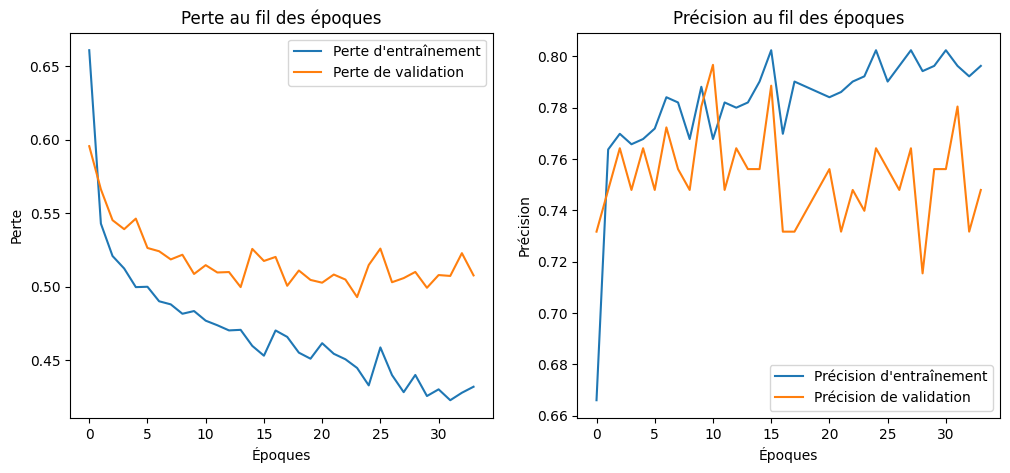

5/5 [==============================] - 0s 572us/step - loss: 0.5588 - accuracy: 0.7468
Précision sur le test : 0.75


In [71]:
# Construction du modèle FFNN avec régularisation L2

model = Sequential()
model.add(Dense(12, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(2, activation='softmax'))  # 2 neurones car nous utilisons l'encodage one-hot

# Utiliser l'optimiseur SGD de l'ancienne API Keras

sgd_optimizer = legacy.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Utilisation de l'arrêt précoce pour éviter le surajustement
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle avec les données one-hot encodées
history = model.fit(X_train, y_train_one_hot, validation_split=0.2, epochs=150, batch_size=10, callbacks=[early_stopping])

# Affichage des courbes d'apprentissage pour la perte et la précision

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Perte au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.title('Précision au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Évaluation du modèle avec les données one-hot encodées
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Précision sur le test : {accuracy:.2f}')

5/5 [==============================] - 0s 487us/step


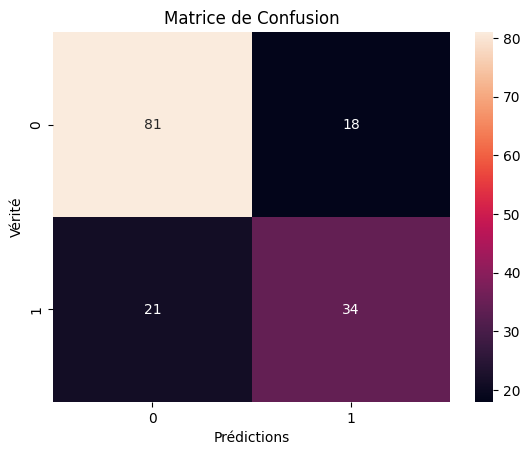

                precision    recall  f1-score   support

Non-Diabétique       0.79      0.82      0.81        99
    Diabétique       0.65      0.62      0.64        55

      accuracy                           0.75       154
     macro avg       0.72      0.72      0.72       154
  weighted avg       0.74      0.75      0.75       154



In [72]:
# Génération des prédictions pour l'ensemble de test
y_pred_probs = model.predict(X_test)

# Récupération des classes prédites
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Affichage de la matrice de confusion
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérité')
plt.show()

# Affichage du rapport de classification
print(classification_report(y_true_classes, y_pred_classes, target_names=['Non-Diabétique', 'Diabétique']))
